# VisionTransformer (ViT) and a text decoder setup (e.g., TrOCR from Hugging Face).

**Step 1: Install Required Libraries**

In [ ]:
!pip install datasets
!pip install transformers datasets


**Step 2: Import Libraries and Load Model Components**

Load the Vision Transformer and tokenizer, and set up the feature extractor and tokenizer for preprocessing.

In [ ]:
pip install pillow

In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from datasets import Dataset
import torch
import os
from PIL import Image

# Initialize model, feature extractor, and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
feature_extractor = ViTImageProcessor.from_pretrained("microsoft/trocr-base-stage1")
tokenizer = AutoTokenizer.from_pretrained("microsoft/trocr-base-stage1")

# Set decoder_start_token_id and pad_token_id
model.config.decoder_start_token_id = tokenizer.cls_token_id
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.bos_token_id

# Set pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Ensure model is set to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encod

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

**Step 3: Data Loading and Preprocessing**

Write functions to load each image and its corresponding text file.

In [2]:
from PIL import Image, UnidentifiedImageError

def load_data(image_folder, text_folder, max_files=300):
    data = []
    img_files = os.listdir(image_folder)[:max_files]  # Get only the top 300 files
    for img_name in img_files:
        img_path = os.path.join(image_folder, img_name)
        txt_path = os.path.join(text_folder, img_name.replace('.jpeg', '.txt'))

        try:
            # Read image
            image = Image.open(img_path).convert("RGB")

            # Read text
            with open(txt_path, 'r', encoding='utf-8') as file:
                text = file.read().strip()

            data.append({"image": image, "text": text})
        except UnidentifiedImageError:
            print(f"Skipping file {img_name} as it is not a valid image")
        except FileNotFoundError:
            print(f"Skipping file {img_name} as corresponding text file is not found")
    return data

# Load data
image_folder = "Source_jpeg"
text_folder = "Source_text"
dataset = load_data(image_folder, text_folder)


Skipping file desktop.ini as it is not a valid image


**Step 4: Preprocess Each Image and Text Pair**

Convert each image to patches, tokenize the corresponding text, and prepare them as tensors for the model.

In [3]:
def preprocess(data):
    pixel_values = []
    labels = []

    for item in data:
        # Process image to pixel values (patches handled internally by ViT feature extractor)
        pixel_value = feature_extractor(item["image"], return_tensors="pt").pixel_values
        pixel_values.append(pixel_value)

        # Tokenize text and pad for the decoder
        label = tokenizer(item["text"], padding="max_length", truncation=True, return_tensors="pt").input_ids
        label[label == tokenizer.pad_token_id] = -100  # Ignore padding in loss calculation
        labels.append(label)

    # Convert lists to tensors
    pixel_values = torch.cat(pixel_values)
    labels = torch.cat(labels)

    return {"pixel_values": pixel_values, "labels": labels}

# Preprocess the dataset
processed_data = preprocess(dataset)


**Step 5: Define DataLoader for Training**

With the preprocessed data, create a PyTorch DataLoader for batching.

In [4]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset and DataLoader
tensor_dataset = TensorDataset(processed_data["pixel_values"], processed_data["labels"])
dataloader = DataLoader(tensor_dataset, batch_size=10, shuffle=True)  # Adjust batch size as needed


**Step 6: Training Setup**

Set up the training loop with a custom training loop (since Colab often has memory constraints).

In [5]:
from transformers import AdamW


# Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    for batch in dataloader:
        pixel_values, labels = batch
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} completed. Loss: {loss.item()}")


c:\Users\X579430\.conda\envs\spark\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 completed. Loss: 0.4026259183883667
Epoch 2/10 completed. Loss: 0.058055467903614044
Epoch 3/10 completed. Loss: 0.031047269701957703
Epoch 4/10 completed. Loss: 0.039603907614946365
Epoch 5/10 completed. Loss: 0.024630922824144363
Epoch 6/10 completed. Loss: 0.03978395834565163
Epoch 7/10 completed. Loss: 0.020970311015844345
Epoch 8/10 completed. Loss: 0.036281242966651917
Epoch 9/10 completed. Loss: 0.030678072944283485
Epoch 10/10 completed. Loss: 0.03876585513353348


**Step 7: Inference and Evaluation**

After training, you can test the model on a sample image and its corresponding text:

In [35]:
# Load a sample image
sample_image_path = "./Paige Writing Samples/sample2_PM.jpg"
sample_image = Image.open(sample_image_path).convert("RGB")

# Process image
pixel_values = feature_extractor(sample_image, return_tensors="pt").pixel_values.to(device)

# Generate text prediction
model.eval()
max_new_tokens = 300
with torch.no_grad():
    generated_ids = model.generate(pixel_values, max_new_tokens=max_new_tokens)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Generated Text:", generated_text)


Generated Text: -


**Step 8. Save trained model**

Save trained model to a directory in the folder.

In [16]:
import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

# Assume your model is trained
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").to(device)

# Save the model weights and configuration
save_directory = "./saved_model"
model.save_pretrained(save_directory)

feature_extractor = ViTImageProcessor.from_pretrained("microsoft/trocr-base-stage1")
tokenizer = AutoTokenizer.from_pretrained("microsoft/trocr-base-stage1")

tokenizer.save_pretrained(save_directory)
feature_extractor.save_pretrained(save_directory)


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['./saved_model\\preprocessor_config.json']

**Step 9. Load Model from saved folder**

Load Model for testing

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

# Load the model, tokenizer, and feature extractor
model = VisionEncoderDecoderModel.from_pretrained(save_directory).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(save_directory)


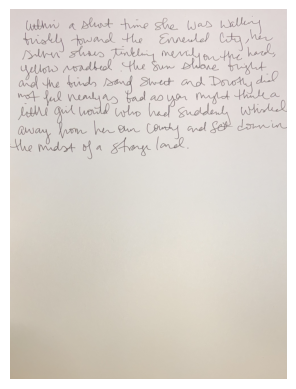

In [9]:
import matplotlib.pyplot as plt

# Load and visualize the sample image
sample_image_path = "./Paige Writing Samples/sample3_PM.jpg"
sample_image = Image.open(sample_image_path).convert("RGB")

# Display the image
plt.imshow(sample_image)
plt.axis("off")
plt.show()
